In [1]:
import torch
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

c:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Local에서 실습 하시는 분은 실행 x
%cd /content/LGES2023_CNN/

#### Custom Dataset

In [2]:
"""
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self):
  데이터셋을 불러오거나 입력받아 전처리를 해주는 부분

  def __len__(self):
  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분
  len을 통해서 getitem의 idx 범위가 결정

  def __getitem__(self, idx): 
  데이터셋에서 특정 1개의 샘플을 가져오는 함수
"""

'\nclass CustomDataset(torch.utils.data.Dataset):\n  def __init__(self):\n  데이터셋을 불러오거나 입력받아 전처리를 해주는 부분\n\n  def __len__(self):\n  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분\n  len을 통해서 getitem의 idx 범위가 결정\n\n  def __getitem__(self, idx): \n  데이터셋에서 특정 1개의 샘플을 가져오는 함수\n'

In [2]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 데이터셋을 한 번에 불러 올 수 있는 경우
class MyDataset(Dataset):
    def __init__(self, mode):
      # load data
      data = pd.read_csv(f'./data/iris.csv')
      
      ## 전처리
      # 입력 변수, 출력 변수 나누기
      X = data[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].to_numpy()
      y = data['Species'].to_numpy()
      
      # 출력 변수 숫자로 변경
      le = LabelEncoder()
      y = le.fit_transform(y)
      
      # train test split
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
      
      if mode == 'train':
        self.X, self.y = X_train, y_train
      elif mode == 'test':
        self.X, self.y = X_test, y_test
      
    def __len__(self):
      return len(self.X)
    
    def __getitem__(self,idx):
      return self.X[idx], self.y[idx]

In [3]:
trainset = MyDataset(mode='train')

print(trainset.__len__())
print(trainset.__getitem__(0))

100
(array([5.6, 2.5, 3.9, 1.1]), 1)


In [4]:
testset = MyDataset(mode='test')

print(testset.__len__())
print(testset.__getitem__(0))

50
(array([5.8, 2.8, 5.1, 2.4]), 2)


In [7]:
# 데이터셋이 관측치마다 파일로 존재하는 경우(일일이 오픈해야 하는 경우)

from glob import glob
from PIL import Image

class MyDataset2(torch.utils.data.Dataset):
    def __init__(self, mode):

      # 모드에 맞는 고양이 이미지 경로 생성
      cat_img_path = glob(f'./data/dog_cat/{mode}/cat/*')
      cat_labels = [0]*len(cat_img_path)
    
      # 모드에 맞는 강아지 이미지 경로 생성
      dog_img_path = glob(f'./data/dog_cat/{mode}/dog/*')
      dog_labels = [1]*len(dog_img_path)
    
      # 이미지 경로 및 레이블 합치기
      self.img_path = cat_img_path + dog_img_path
      self.labels = cat_labels + dog_labels

    def __len__(self):
      return len(self.img_path)
    
    def __getitem__(self,idx):
      crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
      img = Image.open(crt_img_path) # 이미지 오픈
      img = np.asarray(img) # numpy array로 변환 : H,W,3
      X = torch.FloatTensor(img).permute(2,0,1) # tensor로 변환 및 축 변경 : 3,H,W
      
      y = self.labels[idx]
      
      return X, y

In [8]:
trainset2 = MyDataset2(mode='train')
X, y = trainset2.__getitem__(0)

print(trainset2.__len__())
print(X.shape, y)

202
torch.Size([3, 374, 500]) 0


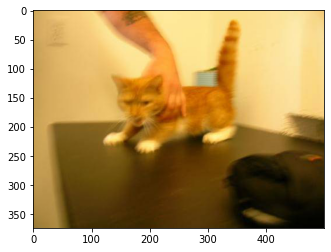

In [9]:
import matplotlib.pyplot as plt
plt.imshow(X.permute(1,2,0).div(255.).numpy())

In [10]:
testset2 = MyDataset2(mode='test')
X, y = testset2.__getitem__(0)

print(testset2.__len__())
print(X.shape, y)

102
torch.Size([3, 375, 499]) 0


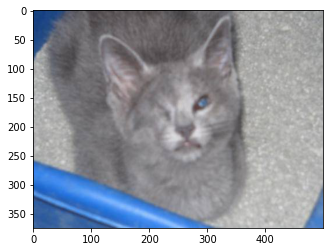

In [11]:
plt.imshow(X.permute(1,2,0).div(255.).numpy())

#### DataLoader

In [12]:
# dataset에서 batch만큼 generate하는 역할
from torch.utils.data import DataLoader

trainloader = DataLoader(dataset=trainset,
                         batch_size=16,
                         shuffle=True,
                         num_workers=0,
                         drop_last=True)

print(trainloader)

In [13]:
for X, y in trainloader:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [16]:
# drop_last는 batch의 마지막 부분을 버릴지 사용할지 선택하는 인자
# 장점 : 모든 데이터셋을 활용가능 / 단점 : batch size가 달라짐
trainloader = DataLoader(dataset=trainset,
                         batch_size=16,
                         shuffle=True,
                         num_workers=0,
                         drop_last=False)

for X, y in trainloader:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([4, 4]) torch.Size([4])


In [17]:
# 이미지의 크기가 다르기 때문에 하나의 tensor로 stack할 수가 없음
trainloader = DataLoader(dataset=trainset2,
                         batch_size=64,
                         shuffle=True,
                         num_workers=0,
                         drop_last=False)

for X, y in trainloader:
    print(X.shape, y.shape)

RuntimeError: stack expects each tensor to be equal size, but got [3, 370, 500] at entry 0 and [3, 374, 500] at entry 1

#### Image Transform
transform document : https://pytorch.org/vision/stable/transforms.html

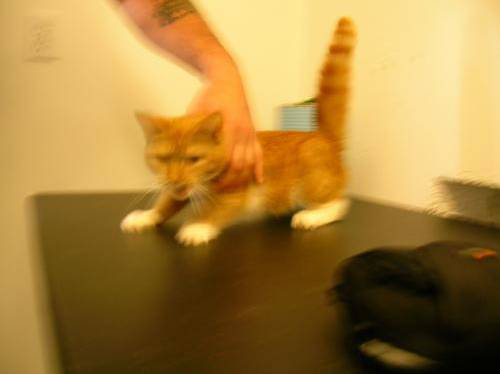

In [19]:
# 이미지에 특화된 패키지인 torchvision을 통해 이미지 변형
import torchvision.transforms as tf

img = Image.open('./data/dog_cat/train/cat/cat.0.jpg')
img

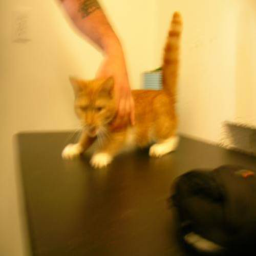

In [20]:
# 이미지 사이즈 변경
resize = tf.Resize(size=(256,256))
resize(img)

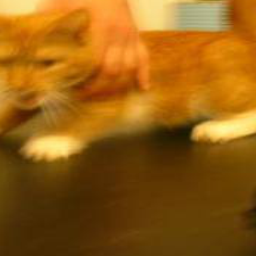

In [21]:
# 이미지 랜덤 크롭
randomcrop = tf.RandomResizedCrop(size=(256,256))
randomcrop(img)

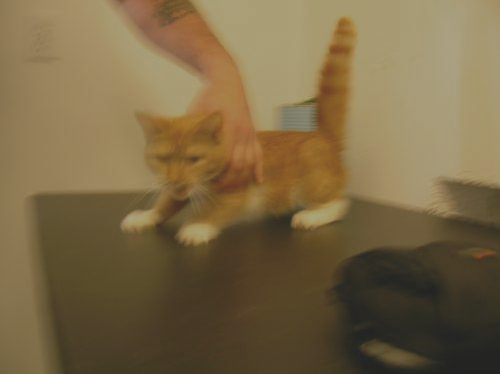

In [22]:
# 밝기, 대비 등 colorjittering
colorjitter = tf.ColorJitter(0.5,0.5,0.5)
colorjitter(img)

In [23]:
# tensor로 변환
totensor = tf.ToTensor()
print(totensor(img)) # 0~1 scale로 변환
print(totensor(img).shape) # C,H,W 순으로 변환

tensor([[[0.7961, 0.7961, 0.8000,  ..., 0.9412, 0.9373, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9333],
         [0.7961, 0.7961, 0.8000,  ..., 0.9451, 0.9412, 0.9373],
         ...,
         [0.6000, 0.6000, 0.6000,  ..., 0.0078, 0.0078, 0.0078],
         [0.5961, 0.5961, 0.5961,  ..., 0.0078, 0.0078, 0.0078],
         [0.5922, 0.5922, 0.5922,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.6431, 0.6431, 0.6471,  ..., 0.7882, 0.7843, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7804],
         [0.6431, 0.6431, 0.6471,  ..., 0.7922, 0.7882, 0.7843],
         ...,
         [0.4784, 0.4784, 0.4784,  ..., 0.0078, 0.0078, 0.0078],
         [0.4745, 0.4745, 0.4745,  ..., 0.0078, 0.0078, 0.0078],
         [0.4706, 0.4706, 0.4706,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.3412, 0.3412, 0.3451,  ..., 0.4784, 0.4745, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.4706],
         [0.3412, 0.3412, 0.3451,  ..., 0.4824, 0.4784, 0.

In [24]:
# 여러 transform 적용
transform = tf.Compose([tf.RandomResizedCrop(size=(256,256)), # 무작위로 크롭하고 사이즈 변경
                        tf.RandomHorizontalFlip(p=0.5), # 이미지를 뒤집는 증강기법
                        tf.RandomRotation(degrees=90)]) # 무작위로 이미지 회전

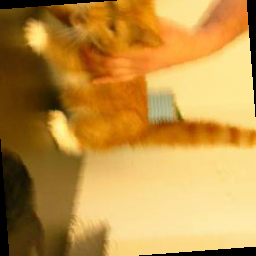

In [25]:
transform(img)

In [26]:
# get_item에서 데이터 변형 후 stack
from glob import glob
from PIL import Image

class MyDataset3(torch.utils.data.Dataset):
    def __init__(self, mode):

      if mode == 'train':
        self.transform = tf.Compose([
                                    # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                    tf.RandomResizedCrop((256,256)),
                                    tf.RandomHorizontalFlip(p=0.5),
                                    tf.ToTensor()
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                  ])
      else: # 테스트의 경우에는 이미지 증강기법을 적용하면 안됨!!
        self.transform = tf.Compose([
                                    tf.Resize(size=(256,256)),
                                    tf.ToTensor(),
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                     ])
        
      # 모드에 맞는 고양이 이미지 경로 생성
      cat_img_path = glob(f'./data/dog_cat/{mode}/cat/*') ##### 변경부분
      cat_labels = [0]*len(cat_img_path)
    
      # 모드에 맞는 강아지 이미지 경로 생성
      dog_img_path = glob(f'./data/dog_cat/{mode}/dog/*') ##### 변경부분
      dog_labels = [1]*len(dog_img_path)
    
      # 이미지 경로 및 레이블 합치기
      self.img_path = cat_img_path + dog_img_path
      self.labels = cat_labels + dog_labels

    def __len__(self):
      return len(self.img_path)
    
    def __getitem__(self,idx):
      crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
      img = Image.open(crt_img_path) # 이미지 오픈
      X = self.transform(img) # 이미지 변형
      
      y = self.labels[idx]
      
      return X, y

torch.Size([3, 256, 256])


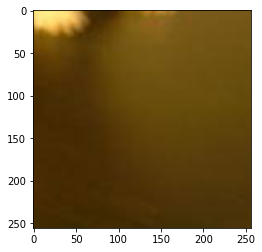

In [39]:
trainset3 = MyDataset3(mode='train')
testset3 = MyDataset3(mode='test')
X, y = trainset3.__getitem__(0)

print(X.shape)
plt.imshow(X.permute(1,2,0).numpy())

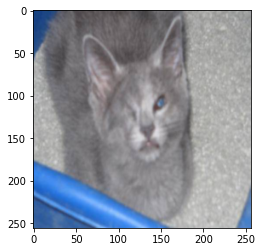

In [40]:
X, y = testset3.__getitem__(0)
plt.imshow(X.permute(1,2,0).numpy())

In [41]:
trainloader = DataLoader(dataset=trainset3,
                         batch_size=64,
                         shuffle=True,
                         num_workers=0,
                         drop_last=False)

for X, y in trainloader:
    print(X.shape, y.shape)

torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([10, 3, 256, 256]) torch.Size([10])
